# Toxic Comment Classification

## Importing required Classes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\agolugur\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


## Importing Data

In [2]:
datatrain = pd.read_csv('train.csv')
datatrain = datatrain.replace(',','')

## Data Pre-Processing

In [3]:
corpus = [] 
for i in range(0,20000):
    review = re.sub(r'[^a-zA-Z\s]', '', str(datatrain['comment_text'][i]))
    review = review.lower()
    review = review.strip()
    ps = PorterStemmer()
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    review = ''.join(review)
    corpus.append(review)

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
cv= CountVectorizer()
x= cv.fit_transform(corpus).toarray()

In [5]:
#Executing the above codes we get about 31000 features. But we want only the most used features and eliminate the rarely used features.

#Reducing the Features to 15000 and Creating the Bag of Words Model
cv=CountVectorizer(max_features=15000)
x= cv.fit_transform(corpus).toarray()
y= datatrain.iloc[0:20000,2].values

## Topic Modelling

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


[('he', 71238.600664630489), ('fr', 20007.097427276731), ('wh', 17201.338883942692), ('re', 15224.784167207143), ('be', 11913.431305070708), ('bu', 11323.097828083422), ('hve', 8969.5644857786174), ('ne', 8521.1969818945181), ('rcle', 8478.2550681966095), ('here', 7246.8226662652642), ('her', 7084.9164284474055), ('cn', 6670.5557817723975), ('ll', 6139.7082049076744), ('ur', 5997.0393333153761), ('ue', 5675.7097210550037), ('ee', 5216.6368418838747), ('er', 4603.5777657688905), ('hnk', 4584.8199456216071), ('pge', 4442.7982663025896), ('ge', 4298.2051812898399), ('le', 4053.1714423145427), ('en', 3941.5043300759326), ('ke', 3853.9379350075901), ('lk', 3782.9811396000509), ('wn', 3722.4036829943807), ('wul', 3658.2741137561707), ('ju', 3518.2694060059525), ('we', 3224.312784308318), ('lke', 3134.8932955950136), ('whch', 3116.5849708177434), ('been', 3067.5907495706247), ('wkpe', 3052.7483398493496), ('ce', 3004.9226670211087), ('nce', 2927.5281444025263), ('ve', 2890.8540629487979), ('u

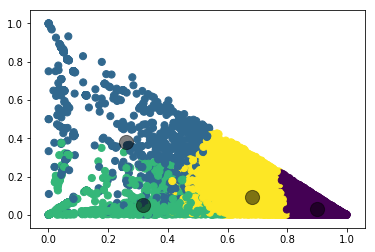

In [6]:
# Creating Topic Modelling
from sklearn.decomposition import LatentDirichletAllocation as LDA
lda = LDA(n_topics = 4, max_iter=100, random_state=100)
x_ld = lda.fit_transform(x)
features = pd.DataFrame(x_ld, columns = ['T1', 'T2', 'T3', 'T4'])


vocab = cv.get_feature_names()
tt_matrix = lda.components_
for topic_weights in tt_matrix:
    topic = [(token, weight) for token, weight in zip(vocab, topic_weights)]
    topic = sorted(topic, key=lambda x: -x[1])
    topic = [item for item in topic if item[1] > 0.6]
    print(topic)

from sklearn.cluster import KMeans

#K-Means Clustering
km = KMeans(n_clusters=4, random_state=0)
km.fit_transform(features)
cluster_labels = km.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel']) #Y-value
kmeansdata = pd.concat([datatrain, cluster_labels], axis=1)

km.fit(x_ld)
y_kmeans = km.predict(x_ld)
plt.scatter(x_ld[:, 0], x_ld[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = km.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.show()

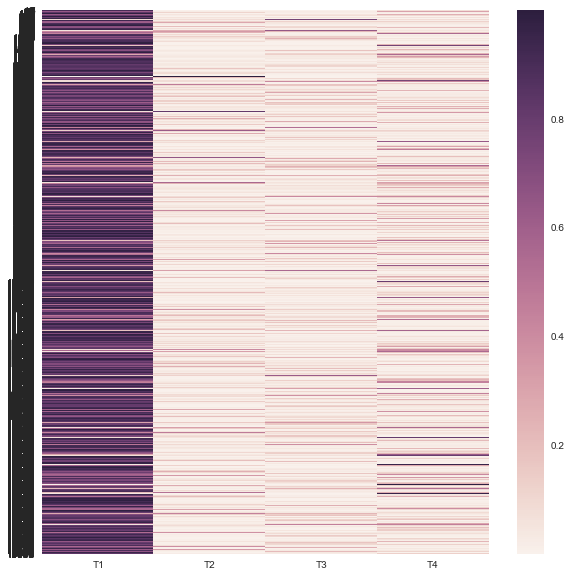

In [30]:
#Visualizing the Topics
from numpy.random import randn
from scipy import stats
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

#HeatMap of the Topics
fig, ax = plt.subplots(figsize=(10, 10))        
sns.heatmap(features, ax=ax)
plt.show()

### Spliting Data

In [7]:
from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 0)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Naive Bayes Classifier

[[2457 1148]
 [   0  395]]
Normalized confusion matrix
[[ 0.6815534  0.3184466]
 [ 0.         1.       ]]


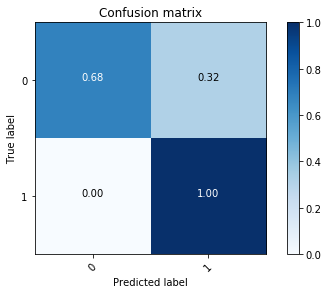

Area under the ROC curve : 0.840777


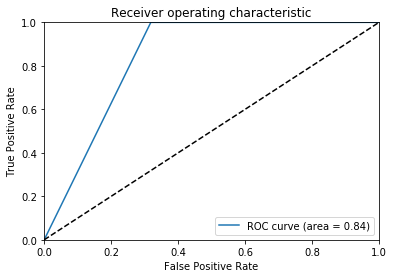

             precision    recall  f1-score   support

          0       1.00      0.68      0.81      3605
          1       0.26      1.00      0.41       395

avg / total       0.93      0.71      0.77      4000

0.417701012986


In [8]:
from sklearn.naive_bayes import GaussianNB
import itertools
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import average_precision_score


classifier = GaussianNB()
classifier.fit(x_train, y_train)

#Partial Fit for Naive Bayes
n = 20000
nbatch1 = 100

#Predicting the test set results for Naive Bayes
from sklearn.metrics import confusion_matrix

for i in range(int(n/nbatch1)):
    classifier.partial_fit(x[i*nbatch1:(i*nbatch1+nbatch1)],y[i*nbatch1:(i*nbatch1+nbatch1)], classes = np.unique(y))
    y_pred_naive = classifier.predict(x_test)

    cm_naive = confusion_matrix(y_test, y_pred_naive)
print(cm_naive)
def plot_confusion_matrix(cm_naive, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm_naive = cm_naive.astype('float') / cm_naive.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm_naive)

    plt.imshow(cm_naive, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm_naive.max() / 2.
    for i, j in itertools.product(range(cm_naive.shape[0]), range(cm_naive.shape[1])):
        plt.text(j, i, format(cm_naive[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm_naive[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
plot_confusion_matrix(cm_naive, [0,1],normalize=True)
def ROC(label,result):
    # Compute ROC curve and area the curve
    Y = np.array(label)
    fpr, tpr, thresholds = roc_curve(Y, result)
    roc_auc = auc(fpr, tpr)
    print("Area under the ROC curve : %f" % roc_auc)

    # Plot ROC curve
    #pl.clf()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
y_score_naive = classifier.predict_proba(x_test)[:,1]
ROC(y_test,y_score_naive)

print(classification_report(y_test,y_pred_naive))

print(matthews_corrcoef(y_test,y_pred_naive))

In [9]:
classifier.score(x_test, y_test)

0.71299999999999997

## Learning Curve

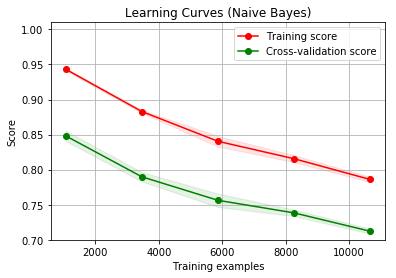

In [10]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

plot_learning_curve(classifier, title, x_train,y_train,ylim=(0.7, 1.01))
plt.show()

## SGD Classifier

In [15]:
#Fitting SGD to the training set
from sklearn.linear_model import SGDClassifier

#Implementing Grid Search to Find the Best Parameters of SGD

param_test1_sgd = {'loss':["log", "hinge"], 'penalty':["l2", "l1", "elasticnet"], 'alpha':[0.00001,0.0001, 0.001, 0.1]}

from sklearn.model_selection import GridSearchCV

gsearch_sgd = GridSearchCV(estimator = SGDClassifier(learning_rate='optimal', random_state=0),
                           param_grid= param_test1_sgd,
                           scoring='accuracy',n_jobs=4, cv=5)

gsearch_sgd.fit(x_train, y_train)
score = gsearch_sgd.score(x_test, y_test)    
print('Accuracy:{}, Best Parameters:{}'.format(score,gsearch_sgd.best_params_))
print(gsearch_sgd.best_params_)



Accuracy:0.91575, Best Parameters:{'alpha': 0.001, 'loss': 'hinge', 'penalty': 'l2'}
{'alpha': 0.001, 'loss': 'hinge', 'penalty': 'l2'}


[[3588   17]
 [ 228  167]]
Normalized confusion matrix
[[ 0.99528433  0.00471567]
 [ 0.57721519  0.42278481]]


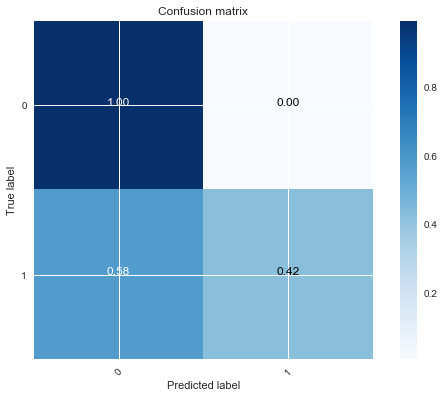

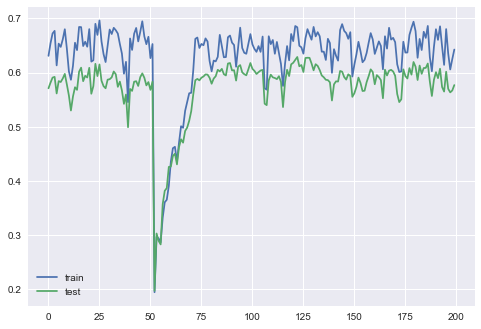

             precision    recall  f1-score   support

          0       0.94      1.00      0.97      3605
          1       0.91      0.42      0.58       395

avg / total       0.94      0.94      0.93      4000

0.595368970397


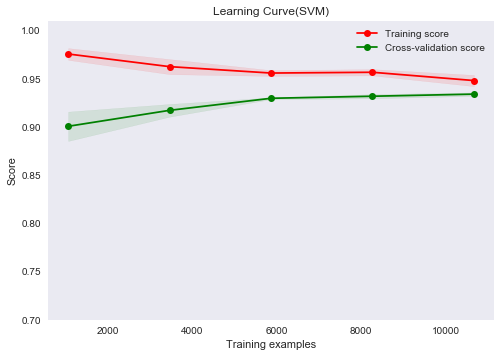

In [16]:
#Fitting the SGD Classifier to the Dataset using the Best Parameters
sgd = SGDClassifier(learning_rate='optimal',alpha=0.001, loss = 'hinge', penalty = 'l2')
sgd.fit(x_train, y_train)
from sklearn.metrics import f1_score
train_score=[]
test_score=[]
iterations=[]

#Partial Fit
n = 20000
nbatch1 = 100

from sklearn.metrics import confusion_matrix

#Predicting the test set results
for i in range(int(n/nbatch1)):
    sgd.partial_fit(x[i*nbatch1:(i*nbatch1+nbatch1)],y[i*nbatch1:(i*nbatch1+nbatch1)], classes = np.unique(y))
    y_pred_sgd = sgd.predict(x_test)
    train_auc=f1_score(y_train, sgd.predict(x_train))
    test_auc=f1_score(y_test,sgd.predict(x_test))
    train_score.append(train_auc)
    test_score.append(test_auc)

    cm_sgd = confusion_matrix(y_test, y_pred_sgd)
print(cm_sgd)
plot_confusion_matrix(cm_sgd, [0,1],normalize=True)
plt.plot(train_score)
plt.plot(test_score)
plt.legend(('train','test'))
plt.show()

print(classification_report(y_test,y_pred_sgd))

print(matthews_corrcoef(y_test,y_pred_sgd))
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
title = "Learning Curve(SVM)"
plot_learning_curve(sgd, title, x_train,y_train,ylim=(0.7, 1.01))
plt.show()

In [17]:
sgd.score(x_test, y_test)

0.93874999999999997

## Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier

#Implementing Grid Search to Find the Best Parameters of Random Forest

param_grid_forest = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
random_forest =  RandomForestClassifier(n_estimators=10,random_state=42)

gsearch_forest =  RandomizedSearchCV(estimator = random_forest,
                                                param_distributions = param_grid_forest,
                                                n_iter = 100, cv = 3, verbose=2, 
                                                random_state=42, n_jobs = -1)

#Fitting the Random Forest to the Dataset
gsearch_forest= gsearch_forest.fit(x_train, y_train)
score = gsearch_forest.score(x_test, y_test)    
print('Accuracy:{}, Best Parameters:{}'.format(score,gsearch_forest.best_params_))
print(gsearch_forest.best_params_)

#Confusion Matrix for Random Forest

from sklearn.metrics import confusion_matrix

y_pred_random = gsearch_forest.predict(x_test)
cm_random = confusion_matrix(y_test, y_pred_random)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 14.5min finished


Accuracy:0.92125, Best Parameters:{'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 10, 'max_depth': None, 'criterion': 'entropy', 'bootstrap': False}
{'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 10, 'max_depth': None, 'criterion': 'entropy', 'bootstrap': False}


In [19]:
gsearch_forest.score(x_test, y_test)

0.92125000000000001

[[3603    2]
 [ 313   82]]
Normalized confusion matrix
[[  9.99445215e-01   5.54785021e-04]
 [  7.92405063e-01   2.07594937e-01]]


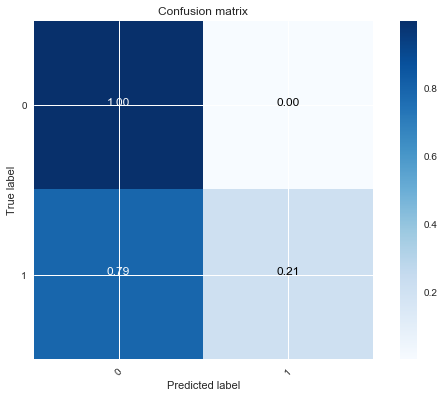

Area under the ROC curve : 0.850886


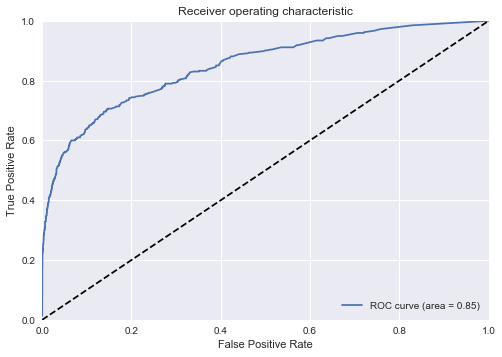

             precision    recall  f1-score   support

          0       0.92      1.00      0.96      3605
          1       0.98      0.21      0.34       395

avg / total       0.93      0.92      0.90      4000

0.430769330176
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   55.8s finished


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.9min finished


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.7min finished


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.6min finished


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  8.6min finished


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   52.3s finished


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.8min finished


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.7min finished


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.7min finished


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   48.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  8.9min finished


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   54.9s finished


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.8min finished


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.8min finished


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.8min finished


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  8.9min finished


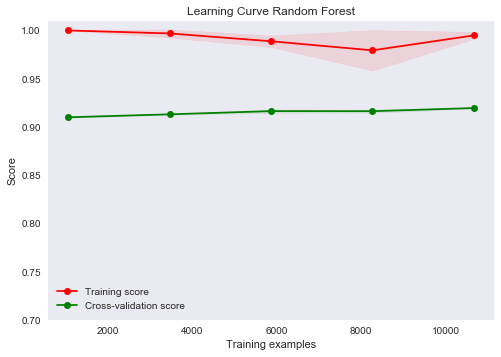

In [20]:
print(cm_random)
plot_confusion_matrix(cm_random, [0,1],normalize=True)
y_score_random = gsearch_forest.predict_proba(x_test)[:,1]
ROC(y_test,y_score_random)
print(classification_report(y_test,y_pred_random))

print(matthews_corrcoef(y_test,y_pred_random))
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
title = "Learning Curve Random Forest"
plot_learning_curve(gsearch_forest, title, x_train,y_train,ylim=(0.7, 1.01))
plt.show()


## Multinomial Naive Bayes

In [10]:
from sklearn.naive_bayes import MultinomialNB
import itertools
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import average_precision_score


In [11]:
#Implementing Grid Search to Find the Best Parameters of SGD

param_test1_mnb = {'alpha':[0.0001, 0.001, 0.1, 1], 
                   "fit_prior": [True, False]}

from sklearn.model_selection import GridSearchCV

gsearch_mnb = GridSearchCV(estimator = MultinomialNB(),
                           param_grid= param_test1_mnb,
                           scoring='accuracy',n_jobs=4, cv=5)

gsearch_mnb.fit(x_train, y_train)
score = gsearch_mnb.score(x_test, y_test)    
print('Accuracy:{}, Best Parameters:{}'.format(score,gsearch_mnb.best_params_))
print(gsearch_mnb.best_params_)


Accuracy:0.929, Best Parameters:{'alpha': 1, 'fit_prior': True}
{'alpha': 1, 'fit_prior': True}


[[2450 1155]
 [   0  395]]
Normalized confusion matrix
[[ 0.67961165  0.32038835]
 [ 0.          1.        ]]


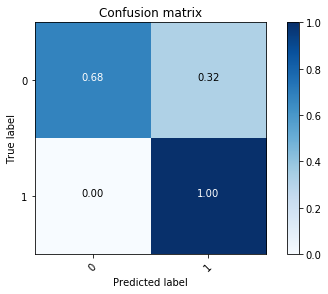

Area under the ROC curve : 0.909974


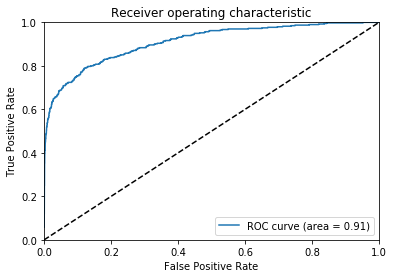

             precision    recall  f1-score   support

          0       0.95      0.99      0.97      3605
          1       0.85      0.55      0.67       395

avg / total       0.94      0.95      0.94      4000

0.660204576032


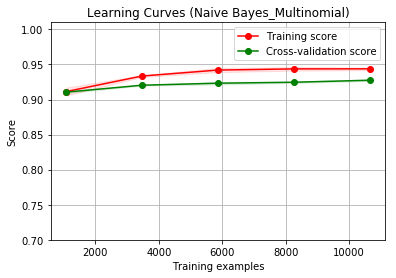

In [12]:
#Using the Best Parameters inside the Classifier
classifiermnb = MultinomialNB(alpha =1, fit_prior=True )
#Partial Fit for Naive Bayes
n = 20000
nbatch1 = 100

for i in range(int(n/nbatch1)):
    classifiermnb.partial_fit(x[i*nbatch1:(i*nbatch1+nbatch1)],y[i*nbatch1:(i*nbatch1+nbatch1)], classes = np.unique(y))
    y_pred_naivemnb = classifiermnb.predict(x_test)

    cm_naivemnb = confusion_matrix(y_test, y_pred_naive)
print(cm_naivemnb)
plot_confusion_matrix(cm_naivemnb, [0,1],normalize=True)

    
y_score_naivemnb = classifiermnb.predict_proba(x_test)[:,1]
ROC(y_test,y_score_naivemnb)

print(classification_report(y_test,y_pred_naivemnb))

print(matthews_corrcoef(y_test,y_pred_naivemnb))

title = "Learning Curves (Naive Bayes_Multinomial)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

plot_learning_curve(classifiermnb, title, x_train,y_train,ylim=(0.7, 1.01))
plt.show()

In [29]:
classifiermnb.score(x_test, y_test)

0.94699999999999995

## Multi Layer Perception

[[3596    9]
 [ 243  152]]
Area under the ROC curve : 0.916867


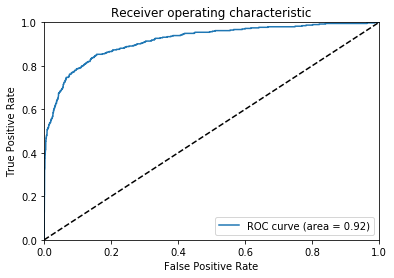

             precision    recall  f1-score   support

          0       0.94      1.00      0.97      3605
          1       0.94      0.38      0.55       395

avg / total       0.94      0.94      0.92      4000

0.580295133986


In [11]:
from sklearn.neural_network import MLPClassifier
classifiermlp = MLPClassifier(solver='adam',hidden_layer_sizes=30,alpha=1e-04)
for i in range(int(n/nbatch1)):
    classifiermlp.partial_fit(x[i*nbatch1:(i*nbatch1+nbatch1)],y[i*nbatch1:(i*nbatch1+nbatch1)], classes = np.unique(y))
    y_pred_mlp = classifiermlp.predict(x_test)

    cm_mlp = confusion_matrix(y_test, y_pred_mlp)
print(cm_mlp)
y_score_mlp = classifiermlp.predict_proba(x_test)[:,1]
ROC(y_test,y_score_mlp)
plt.figure()
print(classification_report(y_test,y_pred_mlp))
print(matthews_corrcoef(y_test,y_pred_mlp))

Normalized confusion matrix
[[ 0.99750347  0.00249653]
 [ 0.61518987  0.38481013]]


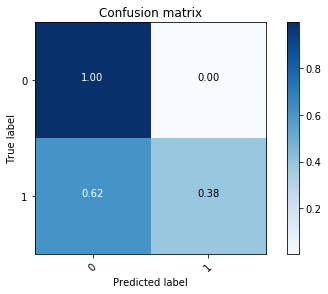

In [12]:
plt.figure()
plot_confusion_matrix(cm_mlp, [0,1],normalize=True)
plt.show()

In [13]:
classifiermlp.score(x_test, y_test)

0.93700000000000006

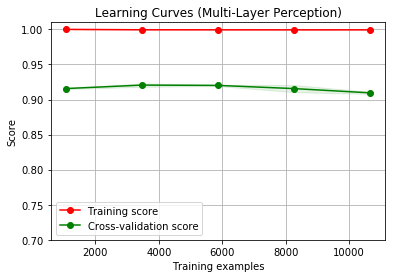

In [15]:
plt.figure()
title = "Learning Curves (Multi-Layer Perception)"
plot_learning_curve(classifiermlp, title, x_train,y_train,ylim=(0.7, 1.01))
plt.show()